<a name="top"></a>

# Land Use and Land Change Analysis for Fray Jorge reserve
Developed by Diego Ocampo Melgar

**University of La Serena**

[Contact](diego.ocampo.melgar@gmail.com)

## Index

[Dependencies](#setup)

[Configuration](#config)

[My functions](#function)

[Get data](#get)

[Unsupervised Cluster classification](#cluster)

[Loop de entrenamiento por clases](#loop)

[Integrar datos](#join)

[Limpieza de datos](#clean)

[Diseño del modelo FNN](#model)

[Entrenamiento del modelo](#train)

[Desempeño del modelo](#performance)

[Predicción](#predict)

[Visualización](#view)


https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/01.01.Getting_Started_ODC_and_Colab.ipynb

https://github.com/ceos-seo/odc-colab/blob/master/notebooks/

Pending:
- Cloud detection algorithms
- Cohen-Braaten-Yang cloud detection
- Hollstein Clouds, Cirrus, Snow, Shadow, Water and Clear Sky Pixels detection
- Cloudless Mosaic
- Cloud statistics
- Observation outlier detection

https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel/sentinel-2/

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jan  4 21:28:45 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   47C    P8              13W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


<a name="setup"></a>
# Dependencies



In [3]:

!pip install rioxarray
!pip install earthengine-api==0.1.328
!pip install scikit-image
!pip install odc.algo
!pip install odc.io.xarray
!pip install postgresql


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.5 MB/s eta 0:00:00
  Created wheel for earthengine-api: filename=earthengine_api-0.1.328-py3-none-any.whl size=273026 sha256=4ff82ec4a7694ba25e032af7c195752b653ebfe32747a80e802058d372086937
  Stored in directory: /root/.cache/pip/wheels/35/e6/99/d8bdf2d52fb281a49b7cb81ffae31baa137fa4c8b2ff7096e1
  Created wheel for httplib2shim: filename=httplib2shim-0.0.3-py2.py3-none-any.whl size=18041 sha256=d4988557ab2ba5e4bec1ae1f6b53643db05d14a2f1d569ee0ce0a49d28abd9b3
  Stored in directory: /root/.cache/pip/wheels/88/e5/dd/0096092515d7a3711c1bbc6c2ea1933a1fe1a62da93a6072a0
Successfully built earthengine-api httplib2shim
 

In [4]:
#!pip install geemap==0.10.0
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py

--2025-01-04 21:31:15--  https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15880 (16K) [text/plain]
Saving to: ‘odc_colab.py’

odc_colab.py        100%[===================>]  15.51K  --.-KB/s    in 0s      

2025-01-04 21:31:15 (137 MB/s) - ‘odc_colab.py’ saved [15880/15880]



In [5]:
from google.colab import drive
drive.mount('/content/drive')
# Suppress Warning Messages
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [6]:
# https://developers.google.com/earth-engine/datasets
import odc_colab
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)
from odc_colab import populate_db
populate_db()


Module utils was not found; cloning https://github.com/ceos-seo/data_cube_utilities.git to CWD...
Package postgresql was not found; installing it...
Module odc-gee was not found; cloning https://github.com/ceos-seo/odc-gee.git to CWD...
No database file supplied. Downloading default index.
Cleaned up extracted database files.


In [7]:

# Load Data Cube Configuration
from odc_gee import earthengine
dc = earthengine.Datacube(app='ee-eartheye')
# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api
api = dc_api.DataAccessApi()
# Import Utilities
import xarray as xr


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=hgIqZASFrynj21TRDv5_Rkw16t4WvNJHPm452GOENmg&tc=ui4ib78zDYNE3QptiSvYBsz6PhLjctbQ5BSVlO6WfrE&cc=WLlDNom7MOzuOz5aKx49FkuQ9JXdZxcfhM5LxTOtgCE

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AanRRrteD0KF9tOs_xQAKXo_iax0c5t9zpP3cQ2bHyOifLw5ZzScahD0tl4

Successfully saved authorization token.


/usr/local/lib/python3.10/dist-packages/datacube/drivers/driver_cache.py:50: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/usr/local/lib/python3.10/dist-packages/datacube/drivers/postgres/_connections.py:81: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  EngineUrl(
/usr/local/lib/python3.10/dist-packages/datacube/drivers/postgres/_connections.py:81: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  EngineUrl(


In [8]:

import os
import rasterio as rio
import pandas as pd
import numpy as np
from odc.algo import keep_good_only
from odc.algo import to_f32
import rioxarray
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as mcolors
from skimage.feature import graycomatrix, graycoprops


<a name="config"></a>
# Configuration

In [12]:
np.random.seed(1006)
output_crs = "epsg:5361"
# Set the output resolution.
resolution_s2 = (-10, 10)
# Bands
bands = ['water_vapor', 'red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'red_edge1', 'red_edge2', 'red_edge3', 'scl']#'cloud_mask'
sr_bands = ['red', 'green', 'blue', 'nir']
indices=['water_vapor', 'red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'red_edge1', 'red_edge2', 'red_edge3', "NDVI",'kNDVI',"IAVI","OSAVI","EVI","SAVI","EBBI","NDMI","MSBI","NMDI","NDWI","MNDVI",'ANDWI',"NDBI","BU",'Brightness','Greeness','Wetness']
allVars = ['water_vapor', 'red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'red_edge1', 'red_edge2', 'red_edge3', "NDVI",'kNDVI',"IAVI","OSAVI","EVI","SAVI","EBBI","NDMI","MSBI","NMDI","NDWI","MNDVI",'ANDWI',"NDBI","BU",'Brightness','Greeness','Wetness', 'elevation', 'aspect', 'slope', 'tri']
scale,offset = (1/10_000, 0)
product = "s2_google"
platform = "Sentinel-2A"
dem_product = "nasadem_google"
time_range = ('2024-01-01', '2024-01-31')
outputPath = "/content/drive/MyDrive/Colab Notebooks/Fray Jorge LULC/output"
inputPath = "/content/drive/MyDrive/Colab Notebooks/Fray Jorge LULC/input"

#clases = ["urban",
#          "arid",
#          "green",
#          "crop",
#          "water",
#          "bare"]

#clas_num = [1,
#            2,
#            3,
#            4,
#            5,
#            0]
#clas_dict = dict(zip(clases, clas_num))


[Back to the top](#top)

<a name="function"></a>
# My functions

In [13]:

def calculate_tri(dem_data, window_size=3):
    # Calculate the standard deviation of elevation within a window
    std_elev = dem_data['elevation'].rolling({'x': window_size, 'y': window_size}, center=True).std().dropna('x', how='all').dropna('y', how='all')

    # Calculate TRI
    tri = std_elev
    return tri


In [14]:

def build_cloud_coverage_table_sentinel(product,platform,latitude,longitude,#measurements,
                                        time=None,dc=None,extra_band='green'):

    load_params = dict(product=product,platform=platform,latitude=latitude,
                       longitude=longitude,group_by='solar_day',measurements=[extra_band,'scl'])

    if time is not None:
        load_params["time"] = time

    geo_data = dc.load(**load_params)

    times = list(geo_data.time.values)
    dates = [dt.astype('datetime64[D]') for dt in geo_data.time.values]

    scene_slice_list = list(map(lambda t: geo_data.sel(time = t), times))

    nodata_mask_list = (geo_data.scl.values == 0)

    cloud_mask_list = (geo_data.scl.values == 1) | (geo_data.scl.values == 3) | (geo_data.scl.values == 8) | \
                      (geo_data.scl.values == 9) | (geo_data.scl.values == 10)

    clean_mask_list = (~nodata_mask_list & ~cloud_mask_list)

    clean_percent = [clean_mask.mean()*100 for clean_mask in clean_mask_list]
    cloud_percent = [cloud_mask.mean()*100 for cloud_mask in cloud_mask_list]
    nodata_percent = [nodata_mask.mean()*100 for nodata_mask in nodata_mask_list]

    clean_count = list(map(np.sum, clean_mask_list))
    total_count = list(map(np.sum, ~nodata_mask_list))

#     data = {"Dates": dates,
#             "clean_percentage": percentage_list,
#             "clean_count": clean_pixel_count_list }
    data = {"Date": dates,"Clean_percent": clean_percent,"Cloud_percent": cloud_percent,
            "NoData_percent": nodata_percent,"Clean_count": clean_count,"Total_count": total_count}

    return pd.DataFrame(data=data, columns=list(data.keys()))#extra_band


In [15]:

def process_cell_data(cell, dc, dem_product, platform, time_range, product, output_crs, outputPath, bands, scale, offset, indices, tag, index, grid_shp):
    # Define the area and load DEM
    geometry = cell.geometry
    area_buff = cell.geometry.buffer(0.01)
    limits = area_buff.bounds
    latitude = (limits[1], limits[3])
    longitude = (limits[0], limits[2])

    dem_dataset = dc.load(latitude=latitude, longitude=longitude, product=dem_product)
    dem_dataset = dem_dataset.rio.reproject(output_crs)
    elevation = dem_dataset.elevation.squeeze().drop('time')
    ds1 = elevation.to_dataset()

    # Calculate slope and aspect
    resolution_dem = 30  # Set resolution based on your DEM
    dy, dx = np.gradient(elevation, resolution_dem)
    aspect = np.arctan2(-dx, dy)
    aspect_degrees = np.degrees(aspect)
    aspect_degrees = (aspect_degrees + 360) % 360
    flat_areas = (dy == 0) & (dx == 0)
    aspect_degrees[flat_areas] = -1
    ds1['aspect'] = (('y', 'x'), aspect_degrees)

    slope_radians = np.arctan(np.sqrt(dx**2 + dy**2))
    slope_percentage = np.tan(slope_radians) * 100
    ds1["slope"] = (('y', 'x'), slope_percentage)

    # TRI calculation
    tri = calculate_tri(dem_dataset)  # Assuming calculate_tri is a predefined function
    ds1["tri"] = elevation
    tri_resampled = tri.squeeze().drop('time').interp_like(ds1['elevation'])
    ds1["tri"].data = tri_resampled.data

    # Load Sentinel-2 data and calculate indices
    sentinel_dataset = dc.load(
        latitude=latitude,
        longitude=longitude,
        platform=platform,
        time=time_range,
        product=product,
        group_by='solar_day',
        measurements=bands
    )
    sentinel_dataset = sentinel_dataset.rio.reproject(output_crs)
    data = to_f32(sentinel_dataset, scale=scale, offset=offset)  # Assuming to_f32 is a predefined function

    # Calculate indices
    data["NDMI"] = (data.nir - data.swir1) / (data.nir  + data.swir1)
    data["MSBI"] = (0.406*data.green) + (0.60*data.red) + (0.645*data.red_edge2) + (0.243*data.water_vapor) #https://www.indexdatabase.de/db/i-single.php?id=570
    data["MNDVI"] = (data.green - data.swir1) / (data.green + data.swir1)
    data["IAVI"] = (data.nir - (data.red - ((1.12 + 0.65) / 2)*(data.blue - data.red))) / (data.nir + (data.red - ((1.12 + 0.65) / 2)*(data.blue - data.red)))
    data["OSAVI"] = ((1 + 0.16)*(data.nir - data.red)) / (data.nir + data.swir1 + 0.61)
    data["EVI"] = 2.5 * (data.nir - data.red) / (data.nir + (6.0*data.red) - (7.5*data.blue)+ 1)
    data["SAVI"] = ((data.nir-data.red) / (data.nir + data.red + 0.5)) * (1+0.5)
    data["EBBI"] = (data.nir-data.red) / (10 * np.sqrt(data.nir + 0.5))
    data["NMDI"] = (data.nir  - ( data.swir1 - data.red_edge2 ) ) / ( data.nir  + ( data.swir1 - data.swir2) )
    data["NDVI"] = (data.nir  - data.red) / (data.nir  + data.red)
    data["NDWI"] = (data.green - data.nir ) / (data.green + data.nir ) #https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndwi/
    data["NDSI"] = (data.green - data.swir1) / (data.green + data.swir1) # https://doi.org/10.5194/essd-11-493-2019
    data["NDBI"] = (data.swir1 - data.nir ) / (data.swir1 + data.nir )
    data["BU"] = data.NDBI - data.NDVI # https://www.tandfonline.com/doi/pdf/10.1080/01431161.2010.481681
    data['ANDWI'] = (data['blue']+data['green']+data['red']-data['nir']-data['swir1']-data['swir2']) / (data['blue']+data['green']+data['red']+data['nir']+data['swir1']+data['swir2'])
    sigma = 0.5*(data['nir'] + data['red'])
    knr = np.exp(-(data['nir'] - data['red'])**2/(2*sigma**2))
    data['kNDVI'] = (1-knr) / (1+knr)
    data['Brightness'] = 0.3510*data['blue'] + 0.3813*data['green'] + 0.3437*data['red'] + 0.7196*data['nir'] + 0.2396*data['swir1'] + 0.1949*data['swir2']
    data['Greeness'] = -0.3599*data['blue'] - 0.3533*data['green'] - 0.4734*data['red'] + 0.6633*data['nir'] + 0.0087*data['swir1'] - 0.2856*data['swir2']
    data['Wetness'] = 0.2578*data['blue'] + 0.2305*data['green'] + 0.0883*data['red'] + 0.1071*data['nir'] - 0.7611*data['swir1'] - 0.5308*data['swir2']

    # Monthly mean indices
    mean_indices = data[indices].groupby('time.month').mean('time')
    mean_indices = mean_indices.dropna(dim='month', how='all')

    # Merge DEM data
    mean_indices['elevation'] = ds1.elevation.interp(y=mean_indices["y"], x=mean_indices["x"])
    mean_indices['aspect'] = ds1.aspect.interp(y=mean_indices["y"], x=mean_indices["x"])
    mean_indices['slope'] = ds1.slope.interp(y=mean_indices["y"], x=mean_indices["x"])
    mean_indices['tri'] = ds1.tri.interp(y=mean_indices["y"], x=mean_indices["x"])

    # Filtering and clipping
    mean_indices = mean_indices.where(mean_indices['elevation'] > 0, drop=False)
    mean_indices = mean_indices.squeeze().drop('elevation')
    gdf = gpd.GeoSeries([geometry], crs=grid_shp.crs)
    gdf = gdf.to_crs(32719)
    clipped_data = mean_indices.rio.clip(gdf.geometry, gdf.crs, drop=False)

    # Convert to DataFrame
    stacked_data = clipped_data.stack(z=("x", "y"))
    stacked_data = stacked_data.drop_vars(['x', 'y', 'z'], errors="ignore")
    df_pixels = stacked_data.to_dataframe().reset_index()
    df_pixels = df_pixels.dropna()
    # Save to CSV
    output_path = outputPath + "/" + tag + "/data_" + tag + "_" + str(index) + ".csv"
    #output_path = f"/content/drive/MyDrive/Work/Gruner_2024/ML_grid/clases/output/{tag}/data_{tag}_{index}.csv"
    df_pixels.to_csv(output_path, index=False)

    # Clean up to free memory
    del dem_dataset, ds1, data, sentinel_dataset, tri, tri_resampled, mean_indices
    mssg = "finished cell: " + str(index) +" saved to" + output_path
    return mssg  # Optionally return the DataFrame for further use


In [16]:

def process_cell_data_predict(latitude, longitude, dc, dem_product, platform, time_range, product, output_crs, outputPath, bands, scale, offset, indices):
    # Define the area and load DEM
    dem_dataset = dc.load(latitude=latitude, longitude=longitude, product=dem_product)
    dem_dataset = dem_dataset.rio.reproject(output_crs)
    elevation = dem_dataset.elevation.squeeze().drop('time')
    ds1 = elevation.to_dataset()

    # Calculate slope and aspect
    resolution_dem = 30  # Set resolution based on your DEM
    dy, dx = np.gradient(elevation, resolution_dem)
    aspect = np.arctan2(-dx, dy)
    aspect_degrees = np.degrees(aspect)
    aspect_degrees = (aspect_degrees + 360) % 360
    flat_areas = (dy == 0) & (dx == 0)
    aspect_degrees[flat_areas] = -1
    ds1['aspect'] = (('y', 'x'), aspect_degrees)

    slope_radians = np.arctan(np.sqrt(dx**2 + dy**2))
    slope_percentage = np.tan(slope_radians) * 100
    ds1["slope"] = (('y', 'x'), slope_percentage)

    # TRI calculation
    tri = calculate_tri(dem_dataset)
    ds1["tri"] = elevation
    tri_resampled = tri.squeeze().drop('time').interp_like(ds1['elevation'])
    ds1["tri"].data = tri_resampled.data

    # Load Sentinel-2 data and calculate indices
    sentinel_dataset = dc.load(
        latitude=latitude,
        longitude=longitude,
        platform=platform,
        time=time_range,
        product=product,
        group_by='solar_day',
        measurements=bands
    )
    sentinel_dataset = sentinel_dataset.rio.reproject(output_crs)
    data = to_f32(sentinel_dataset, scale=scale, offset=offset)

    # Calculate indices
    data["NDMI"] = (data.nir - data.swir1) / (data.nir  + data.swir1)
    data["MSBI"] = (0.406*data.green) + (0.60*data.red) + (0.645*data.red_edge2) + (0.243*data.water_vapor) #https://www.indexdatabase.de/db/i-single.php?id=570
    data["MNDVI"] = (data.green - data.swir1) / (data.green + data.swir1)
    data["IAVI"] = (data.nir - (data.red - ((1.12 + 0.65) / 2)*(data.blue - data.red))) / (data.nir + (data.red - ((1.12 + 0.65) / 2)*(data.blue - data.red)))
    data["OSAVI"] = ((1 + 0.16)*(data.nir - data.red)) / (data.nir + data.swir1 + 0.61)
    data["EVI"] = 2.5 * (data.nir - data.red) / (data.nir + (6.0*data.red) - (7.5*data.blue)+ 1)
    data["SAVI"] = ((data.nir-data.red) / (data.nir + data.red + 0.5)) * (1+0.5)
    data["EBBI"] = (data.nir-data.red) / (10 * np.sqrt(data.nir + 0.5))
    data["NMDI"] = (data.nir  - ( data.swir1 - data.red_edge2 ) ) / ( data.nir  + ( data.swir1 - data.swir2) )
    data["NDVI"] = (data.nir  - data.red) / (data.nir  + data.red)
    data["NDWI"] = (data.green - data.nir ) / (data.green + data.nir ) #https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndwi/
    data["NDSI"] = (data.green - data.swir1) / (data.green + data.swir1) # https://doi.org/10.5194/essd-11-493-2019
    data["NDBI"] = (data.swir1 - data.nir ) / (data.swir1 + data.nir )
    data["BU"] = data.NDBI - data.NDVI # https://www.tandfonline.com/doi/pdf/10.1080/01431161.2010.481681
    data['ANDWI'] = (data['blue']+data['green']+data['red']-data['nir']-data['swir1']-data['swir2']) / (data['blue']+data['green']+data['red']+data['nir']+data['swir1']+data['swir2'])
    sigma = 0.5*(data['nir'] + data['red'])
    knr = np.exp(-(data['nir'] - data['red'])**2/(2*sigma**2))
    data['kNDVI'] = (1-knr) / (1+knr)
    data['Brightness'] = 0.3510*data['blue'] + 0.3813*data['green'] + 0.3437*data['red'] + 0.7196*data['nir'] + 0.2396*data['swir1'] + 0.1949*data['swir2']
    data['Greeness'] = -0.3599*data['blue'] - 0.3533*data['green'] - 0.4734*data['red'] + 0.6633*data['nir'] + 0.0087*data['swir1'] - 0.2856*data['swir2']
    data['Wetness'] = 0.2578*data['blue'] + 0.2305*data['green'] + 0.0883*data['red'] + 0.1071*data['nir'] - 0.7611*data['swir1'] - 0.5308*data['swir2']

    # Monthly mean indices
    mean_indices = data[indices].groupby('time.month').mean('time')
    mean_indices = mean_indices.dropna(dim='month', how='all')

    # Merge DEM data
    mean_indices['elevation'] = ds1.elevation.interp(y=mean_indices["y"], x=mean_indices["x"])
    mean_indices['aspect'] = ds1.aspect.interp(y=mean_indices["y"], x=mean_indices["x"])
    mean_indices['slope'] = ds1.slope.interp(y=mean_indices["y"], x=mean_indices["x"])
    mean_indices['tri'] = ds1.tri.interp(y=mean_indices["y"], x=mean_indices["x"])

    # Filtering and clipping
    mean_indices = mean_indices.where(mean_indices['elevation'] > 0, drop=False)
    mean_indices = mean_indices.squeeze().drop('elevation')
    # Clean up to free memory
    del dem_dataset, ds1, data, sentinel_dataset, tri, tri_resampled
    return mean_indices  # Optionally return the DataFrame for further use


In [17]:
# Function to remove outliers based on percentiles
def remove_outliers(df, lower_percentile=0.001, upper_percentile=0.999):
    df_clean = df.copy()
    for column in df.columns:
        if column != 'target' and pd.api.types.is_numeric_dtype(df[column]):  # Skip 'target' column and apply only to numeric columns
            lower_bound = df[column].quantile(lower_percentile)
            upper_bound = df[column].quantile(upper_percentile)
            df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
    return df_clean


In [18]:

def plot_true_color(dataset, ax):
    # Extract the red, green, and blue bands from the dataset
    red = dataset['red'].values
    green = dataset['green'].values
    blue = dataset['blue'].values

    # Calculate the 2nd and 98th percentiles for each band
    red_p2, red_p98 = np.percentile(red, (2, 98))
    green_p2, green_p98 = np.percentile(green, (2, 98))
    blue_p2, blue_p98 = np.percentile(blue, (2, 98))

    # Normalize the bands based on the percentile values
    red_norm = np.clip((red - red_p2) / (red_p98 - red_p2), 0, 1)
    green_norm = np.clip((green - green_p2) / (green_p98 - green_p2), 0, 1)
    blue_norm = np.clip((blue - blue_p2) / (blue_p98 - blue_p2), 0, 1)

    # Stack the bands into a 3D array (height, width, 3)
    true_color = np.stack([red_norm, green_norm, blue_norm], axis=-1)

    # Plot the true color image on the given axis
    ax.imshow(true_color)
    ax.set_title("True Color")

def plot_false_color(dataset, ax):
    # Extract the red, green, and blue bands from the dataset
    red = dataset['nir'].values
    green = dataset['green'].values
    blue = dataset['blue'].values

    # Calculate the 2nd and 98th percentiles for each band
    red_p2, red_p98 = np.percentile(red, (2, 98))
    green_p2, green_p98 = np.percentile(green, (2, 98))
    blue_p2, blue_p98 = np.percentile(blue, (2, 98))

    # Normalize the bands based on the percentile values
    red_norm = np.clip((red - red_p2) / (red_p98 - red_p2), 0, 1)
    green_norm = np.clip((green - green_p2) / (green_p98 - green_p2), 0, 1)
    blue_norm = np.clip((blue - blue_p2) / (blue_p98 - blue_p2), 0, 1)

    # Stack the bands into a 3D array (height, width, 3)
    true_color = np.stack([red_norm, green_norm, blue_norm], axis=-1)

    # Plot the true color image on the given axis
    ax.imshow(true_color)
    ax.set_title("False Color")


[Back to the top](#top)

<a name="get"></a>
# Get data

In [19]:
inputPath = "/content/drive/MyDrive/Colab Notebooks/Fray Jorge LULC/input"
shapefile = inputPath + "/FJ_boundary.shp"
time_extents = ('2024-01-01', '2024-01-31')
boundary_shp = gpd.read_file(shapefile)
boundary_shp
limits = boundary_shp.total_bounds
limits
latitude = (limits[1], limits[3])
longitude = (limits[0], limits[2])


In [ ]:

mean_indices = process_cell_data_predict(latitude, longitude, dc, dem_product, platform, time_range, product, output_crs, outputPath, bands, scale, offset, indices)


In [ ]:
# Get the spatial extent
lon_min, lon_max = mean_indices.x.min().item(), mean_indices.x.max().item()
lat_min, lat_max = mean_indices.y.min().item(), mean_indices.y.max().item()

# Generate random points
n_points = 500000
random_lons = np.random.uniform(lon_min, lon_max, n_points)
random_lats = np.random.uniform(lat_min, lat_max, n_points)

# Extract values at random points
points = pd.DataFrame({'x': random_lons, 'y': random_lats})

# Interpolate values for each variable separately and add to 'points' DataFrame
for var in mean_indices.data_vars: # Loop through each variable in mean_indices
    points[var] = mean_indices[var].interp(x=('points', random_lons), y=('points', random_lats)).to_dataframe().reset_index(drop=True)[var] #Interpolate and add as new column

In [ ]:
points

In [ ]:

points.replace([np.inf, -np.inf], np.nan, inplace=True)
points = points.dropna()
points


In [ ]:

points_clean = remove_outliers(points, lower_percentile=0.01, upper_percentile=0.99)
# Removes outliers in 98% distribution


In [ ]:
#allVars.remove("elevation")
points_clean = points_clean[allVars]

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(points_clean)

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Prepare data
scaler = StandardScaler()
X_train = scaler.fit_transform(points_clean[allVars].values.reshape(-1, 1))
X_train

array([[-0.18028145],
       [-0.18285733],
       [-0.18378626],
       ...,
       [ 6.57844665],
       [ 0.11874427],
       [-0.11679589]])

In [ ]:
# prompt: use X_train to train a unsupervised clustering using deep learning

import tensorflow as tf
from sklearn.cluster import KMeans

# Define the autoencoder model
def create_autoencoder(input_dim, encoding_dim):
    input_layer = tf.keras.layers.Input(shape=(input_dim,))
    encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
    decoded = tf.keras.layers.Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = tf.keras.models.Model(input_layer, decoded)
    encoder = tf.keras.models.Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

# Assuming X_train is your preprocessed data
input_dim = X_train.shape[1]
encoding_dim = 32 # You can adjust this
autoencoder, encoder = create_autoencoder(input_dim, encoding_dim)

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True)

# Get the encoded representations
encoded_data = encoder.predict(X_train)

# Apply KMeans clustering to the encoded data
kmeans = KMeans(n_clusters=5, random_state=0) # Adjust n_clusters as needed
kmeans.fit(encoded_data)

# Get cluster labels
cluster_labels = kmeans.labels_

# Now you have cluster_labels for each data point in X_train
cluster_labels

Epoch 1/50
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7086
Epoch 2/50
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5546
Epoch 3/50
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5495
Epoch 4/50
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5472
Epoch 5/50
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5478
Epoch 6/50
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5460
Epoch 7/50
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5449
Epoch 8/50
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5446
Epoch 9/50
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5454
Epoch 10/50
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5470
Epoch 11/50
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5462
Epoch 12/50
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5460
Epoch 13/50
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5451
Epoch 14/50
1342/1342 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5467
Epoch 15/50
1342/1342 ━━━━━━━

array([2, 1, 3, ..., 4, 1, 4], dtype=int32)

10735/10735 ━━━━━━━━━━━━━━━━━━━━ 11s 977us/step


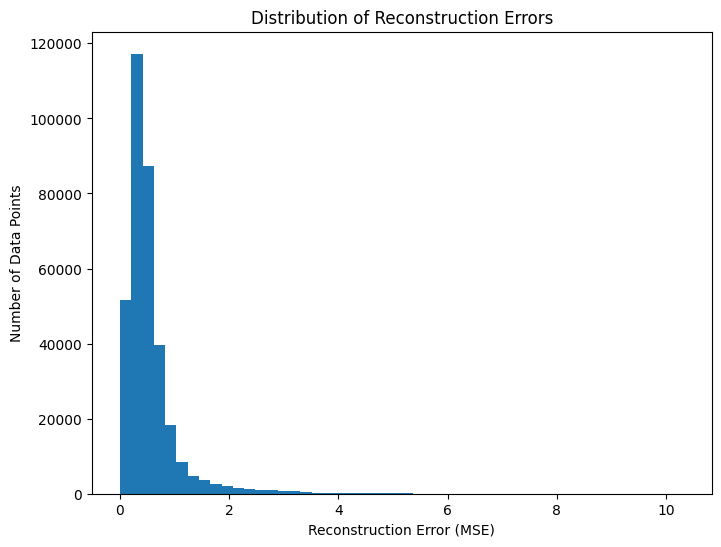

In [ ]:
# prompt: plot the model performance

import matplotlib.pyplot as plt

# Assuming 'autoencoder' is your trained autoencoder model and 'X_train' is your data
reconstructed_data = autoencoder.predict(X_train)

# Calculate the reconstruction error
mse = np.mean(np.power(X_train - reconstructed_data, 2), axis=1)

# Plot the distribution of reconstruction errors
plt.figure(figsize=(8, 6))
plt.hist(mse, bins=50)
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Number of Data Points")
plt.title("Distribution of Reconstruction Errors")
plt.show()

In [ ]:
# Reshape dataset into a feature array
dataset = mean_indices#.to_dataset()
flat_data = dataset.to_array().values.reshape(-1, dataset.dims['y'] * dataset.dims['x'])

# Standardize the data
flat_data = scaler.transform(flat_data.T)

# Predict clusters for all pixels
predicted_clusters = autoencoder.predict(flat_data)
predicted_clusters = predicted_clusters.argmax(axis=1)

# Reshape predictions back to the original dimensions
cluster_map = predicted_clusters.reshape(dataset.dims['lat'], dataset.dims['lon'])

# Save the cluster map as a new xarray.DataArray
cluster_da = xr.DataArray(
    cluster_map,
    dims=('lat', 'lon'),
    coords={'lat': dataset.lat, 'lon': dataset.lon},
    name='clusters'
)

ValueError: Input X contains infinity or a value too large for dtype('float64').


<a name="cluster"></a>
# Unsupervised Cluster classification

## within-cluster sum of squares (WCSS)

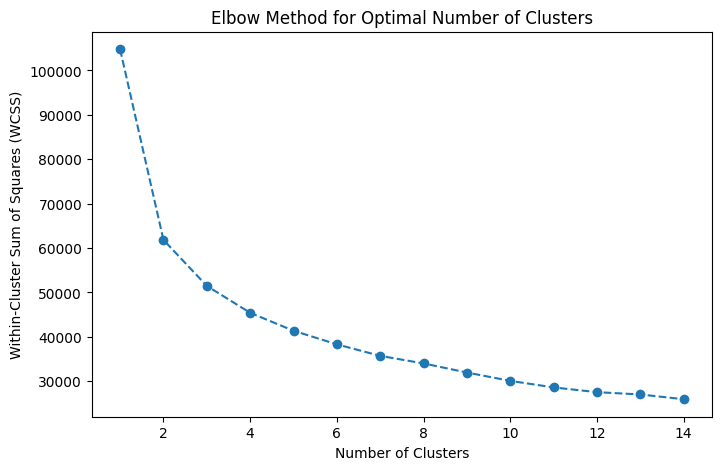

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Define a range for the number of clusters
cluster_range = range(1, 15)
wcss = []

# Calculate WCSS for each number of clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)  # 'features' from the autoencoder's bottleneck layer
    wcss.append(kmeans.inertia_)  # Sum of squared distances to cluster centers

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Prepare data
#scaler = StandardScaler()
#X = scaler.fit_transform(points_clean[allVars].values)

import numpy as np
from sklearn.cluster import KMeans
import tensorflow as tf

# Define the autoencoder model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(X.shape[1],)),  # Feature learning
    tf.keras.layers.Dense(5, activation='relu'),  # Low-dimensional feature space (bottleneck)
    tf.keras.layers.Dense(10, activation='relu'),  # Reconstruction layer
    tf.keras.layers.Dense(X.shape[1])  # Output layer (reconstruction of input)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
model.fit(X, X, epochs=10, batch_size=32, verbose=1)

# **Explicitly call the model to initialize it**
_ = model.predict(X)  # Ensures the computation graph is built

# Extract features from the bottleneck layer
intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.layers[1].output)

# Pass the input data through the intermediate model to get features
features = intermediate_model.predict(X)

# Perform clustering on the extracted features
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(features)

# Assign cluster labels back to your data
points_clean['cluster'] = clusters

# Print the cluster assignments
print(points_clean['cluster'].value_counts())




Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9693
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6562
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3468
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2553
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2296
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1931
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1659
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1484
Epoch 9/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1409
Epoch 10/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1397
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


ValueError: The layer sequential_11 has never been called and thus has no defined input.

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Plot the clusters
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
plt.colorbar(label='Cluster')
plt.title('Clusters Visualized')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()


NameError: name 'features' is not defined

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Prepare data
scaler = StandardScaler()
X = scaler.fit_transform(points_clean[allVars].values.reshape(-1, 1))

# Define a simple clustering network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(5, activation='softmax')  # Assuming 5 clusters
])

# Compile and train the network
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.fit(X, X, epochs=100, batch_size=32)

# Predict clusters
clusters = model.predict(X)
points['cluster'] = clusters.argmax(axis=1)


Epoch 1/100


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 5)

In [ ]:
# Reshape dataset into a feature array
flat_data = dataset.to_array().values.reshape(-1, dataset.dims['lat'] * dataset.dims['lon'])

# Standardize the data
flat_data = scaler.transform(flat_data.T)

# Predict clusters for all pixels
predicted_clusters = model.predict(flat_data)
predicted_clusters = predicted_clusters.argmax(axis=1)

# Reshape predictions back to the original dimensions
cluster_map = predicted_clusters.reshape(dataset.dims['lat'], dataset.dims['lon'])

# Save the cluster map as a new xarray.DataArray
cluster_da = xr.DataArray(
    cluster_map,
    dims=('lat', 'lon'),
    coords={'lat': dataset.lat, 'lon': dataset.lon},
    name='clusters'
)

# Save to a file
#cluster_da.to_netcdf("cluster_map.nc")


## Alternative models

* Traditional Methods for Comparison: Run K-Means or Gaussian Mixture Models (GMM) as baselines.




## Deep Autoencoder for Clustering
Use an autoencoder to reduce dimensionality and extract latent features before clustering.
An autoencoder will reduce the feature space while preserving essential patterns, which can then be clustered effectively.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Input layer
input_dim = 20  # Number of predictors
encoding_dim = 10  # Latent space dimension
latent_dim = 5  # Further reduced latent space for clustering

# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
latent_layer = Dense(latent_dim, activation='relu')(encoder)

# Decoder
decoder = Dense(encoding_dim, activation='relu')(latent_layer)
output_layer = Dense(input_dim, activation='linear')(decoder)

# Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Encoder Model for Clustering
encoder_model = Model(inputs=input_layer, outputs=latent_layer)

# Compile and Train
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100


ValueError: Input 0 of layer "functional_11" is incompatible with the layer: expected shape=(None, 20), found shape=(None, 31)

In [ ]:
# Extract latent features
latent_features = encoder_model.predict(X_train)

# Apply K-Means or another clustering method on latent features
from sklearn.cluster import KMeans

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(latent_features)


## Self-Organizing Map (SOM)
An unsupervised neural network specifically
designed for clustering and visualization.

In [ ]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=879109f03c81c589a1add8b016b58835f112f1e38720d40c7b762ac67f4cba7e
  Stored in directory: /root/.cache/pip/wheels/96/98/a5/52dee3e8ed1dbfc4d77e4da41b6d89dd7ab9ead1b921e766f8
Successfully built minisom


In [ ]:
from minisom import MiniSom

# Initialize SOM
som = MiniSom(x=10, y=10, input_len=input_dim, sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_train)
som.train_random(X_train, 1000)

# Get SOM clusters
cluster_map = np.array([som.winner(x) for x in X_train])


ValueError: Received 31 features, expected 20.

## Deep Embedded Clustering (DEC)
Combines autoencoder with clustering in a unified framework.


In [ ]:

!pip install deep_clustering_toolbox
https://github.com/jizongFox/deep-clustering-toolbox.git

ERROR: Could not find a version that satisfies the requirement deep_clustering_toolbox (from versions: none)
ERROR: No matching distribution found for deep_clustering_toolbox


In [ ]:
# prompt: install these tools:
# https://github.com/jizongFox/deep-clustering-toolbox.git
!git clone https://github.com/jizongFox/deep-clustering-toolbox.git

ERROR: Could not find a version that satisfies the requirement deep_clustering_toolbox (from versions: none)
ERROR: No matching distribution found for deep_clustering_toolbox
Cloning into 'deep-clustering-toolbox'...
remote: Enumerating objects: 25071, done.
remote: Counting objects: 100% (286/286), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 25071 (delta 150), reused 278 (delta 146), pack-reused 24785 (from 1)
Receiving objects: 100% (25071/25071), 315.27 MiB | 13.08 MiB/s, done.
Resolving deltas: 100% (2781/2781), done.


In [ ]:
from deep_clustering_toolbox.models import DEC
from sklearn.preprocessing import StandardScaler

# Preprocess data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define and train DEC
dec = DEC(input_dim=20, z_dim=10, n_clusters=5)
dec.fit(X_train_scaled, pretrain_epochs=100, clustering_epochs=100)

# Predict clusters
clusters = dec.predict(X_train_scaled)


ModuleNotFoundError: No module named 'deep_clustering_toolbox'

## Full Scene Prediction

In [ ]:
# Flatten the dataset
flat_data = dataset.to_array().values.reshape(-1, dataset.dims['lat'] * dataset.dims['lon']).T

# Scale predictors
flat_data_scaled = scaler.transform(flat_data)

# Predict clusters
predicted_clusters = kmeans.predict(flat_data_scaled)  # Or dec.predict()

# Reshape predictions back to original dimensions
cluster_map = predicted_clusters.reshape(dataset.dims['lat'], dataset.dims['lon'])

# Save the cluster map
cluster_da = xr.DataArray(
    cluster_map,
    dims=('lat', 'lon'),
    coords={'lat': dataset.lat, 'lon': dataset.lon},
    name='clusters'
)
cluster_da.to_netcdf("cluster_map.nc")


<a name="loop"></a>
# Loop de entrenamiento por clases

In [ ]:

for clase, num in clas_dict.items():
  print(f"{clase}_{num}")
  grid = inputPath + "/"+clase + str(num)+".shp"
  grid_shp = gpd.read_file(grid)
  #grid_shp_proj = grid_shp.to_crs(output_crs)
  tag = clase
  #print(tag)
  for index, cell in grid_shp.iterrows():
    process_cell_data(cell, dc, dem_product, platform, time_range, product, output_crs, outputPath, bands, scale, offset, indices, tag, index, grid_shp)
    print(index)


bare_0
0
1
2
3
4
5


[Regresar al inicio](#top)

<a name="join"></a>
# Integración de datos

In [ ]:

df_combined = pd.DataFrame()

for clase, num in clas_dict.items():
  print(f"{clase}_{num}")
  folder_path = outputPath + "/" + clase
  csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
  for csv in csv_files:
      csv1=pd.read_csv(folder_path+"/"+csv)
      csv1 = csv1.drop(columns=['x', 'y', 'spatial_ref', 'year'], errors='ignore')
      df_pivot = csv1#.pivot(index='points', columns='variable', values='value')
      df_pivot.reset_index(inplace=True)
      df_pivot["target"] = num
      df_combined = pd.concat([df_combined, df_pivot])

  #df_combined #= df_combined.drop(columns=['x', 'y', 'spatial_ref', 'year'], errors='ignore')
  df_combined = df_combined.drop(columns=['variable','index', 'Unnamed: 0','level_0', 'index','z', 'points', 'month'], errors='ignore')
  df_combined.reset_index(inplace=True)
  df_combined.head()



urban_1
arid_2
green_3
crop_4
water_5
bare_0


In [ ]:
df = df_combined.dropna()
df.describe()

,index,water_vapor,red,green,blue,nir,swir1,swir2,red_edge1,red_edge2,...,ANDWI,NDBI,BU,Brightness,Greeness,Wetness,aspect,slope,tri,target
count,4.159208e+06,4.159208e+06,4.159208e+06,4.159208e+06,4.159208e+06,4.159208e+06,4.159208e+06,4.159208e+06,4.159208e+06,4.159208e+06,...,4.159208e+06,4.159208e+06,4.159208e+06,4.159208e+06,4.159208e+06,4.159208e+06,4.159208e+06,4.159208e+06,4.159208e+06,4.159208e+06
mean,1.975390e+06,4.052582e-01,3.702270e-01,3.302278e-01,2.925906e-01,4.000952e-01,4.241517e-01,3.880380e-01,3.901480e-01,3.972482e-01,...,-1.067744e-01,3.129138e-02,-1.102419e-02,8.210261e-01,-2.389887e-01,-3.017038e-01,1.716996e+02,1.294921e+01,3.276108e+00,2.101161e+00
std,1.197077e+06,1.257622e-01,1.211368e-01,1.038042e-01,9.517589e-02,1.225967e-01,1.264136e-01,1.148665e-01,1.240988e-01,1.205085e-01,...,7.768216e-02,6.566816e-02,1.415534e-01,2.439029e-01,9.309869e-02,9.795751e-02,9.498324e+01,1.596546e+01,3.905794e+00,9.216268e-01
min,0.000000e+00,9.193076e-02,5.641538e-02,5.828461e-02,5.565385e-02,5.705384e-02,7.589230e-02,7.153846e-02,5.393077e-02,5.109231e-02,...,-5.059306e-01,-4.988947e-01,-1.131450e+00,1.349352e-01,-8.629637e-01,-1.079198e+00,-1.000000e+00,0.000000e+00,-2.731342e-16,0.000000e+00
25%,9.334258e+05,3.391167e-01,2.968286e-01,2.684333e-01,2.378000e-01,3.331714e-01,3.479667e-01,3.192500e-01,3.156923e-01,3.300000e-01,...,-1.453341e-01,1.186349e-02,-1.482345e-02,6.755273e-01,-2.995722e-01,-3.563821e-01,9.530420e+01,3.633681e+00,9.911142e-01,2.000000e+00
50%,1.973228e+06,4.028666e-01,3.739333e-01,3.342923e-01,2.960077e-01,4.019333e-01,4.269333e-01,3.949166e-01,3.909714e-01,3.984923e-01,...,-1.004583e-01,3.853224e-02,2.126091e-02,8.231028e-01,-2.523362e-01,-3.010319e-01,1.743050e+02,6.875533e+00,1.769674e+00,2.000000e+00
75%,3.013029e+06,4.697833e-01,4.466000e-01,4.008667e-01,3.541667e-01,4.646000e-01,4.969538e-01,4.555000e-01,4.632833e-01,4.645385e-01,...,-6.491090e-02,6.747056e-02,5.167420e-02,9.668954e-01,-2.007403e-01,-2.432219e-01,2.523436e+02,1.535593e+01,3.894783e+00,2.000000e+00
max,4.052831e+06,9.880429e-01,1.297600e+00,1.181367e+00,1.284600e+00,1.321200e+00,1.295750e+00,1.287550e+00,1.192433e+00,1.194967e+00,...,3.253933e-01,3.739713e-01,4.751674e-01,2.731829e+00,2.798802e-01,1.512869e-01,3.586499e+02,2.724453e+02,6.418125e+01,5.000000e+00


[Regresar al inicio](#top)

<a name="clean_data"></a>
# Limpieza de datos

In [ ]:
df = df.drop(columns = ['index'])
df.to_csv(outputPath+"/data_classes.csv")

In [ ]:
# prompt: show me the unique values for target in df

print(df['target'].unique())

[1 2 3 4 5 0]


In [ ]:


# Assuming your combined dataframe is named 'df'
target_counts = df.groupby('target')['target'].count()

target_counts

,target
target,
0,106376
1,544956
2,2939170
3,62429
4,402801
5,103476


In [ ]:
# Step 2: Clean the data
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
df.dropna(inplace=True)  # Replace NaN with the mean of each column
df.head()

,water_vapor,red,green,blue,nir,swir1,swir2,red_edge1,red_edge2,red_edge3,...,ANDWI,NDBI,BU,Brightness,Greeness,Wetness,aspect,slope,tri,target
0,0.322843,0.276971,0.247800,0.220914,0.302314,0.315871,0.297343,0.287529,0.290614,0.298314,...,-0.104026,0.022179,-0.023275,0.618402,-0.179821,-0.227335,270.441649,19.310372,4.732110,1
1,0.322843,0.285914,0.251371,0.223429,0.302829,0.315871,0.297343,0.287529,0.290614,0.298314,...,-0.093578,0.021956,-0.006839,0.624090,-0.185880,-0.225019,291.905269,15.645151,3.919473,1
2,0.322843,0.281829,0.244314,0.222771,0.301114,0.326057,0.311757,0.304429,0.302971,0.309400,...,-0.113498,0.040219,0.006625,0.623781,-0.186381,-0.242763,146.438188,24.979647,5.955388,1
3,0.322843,0.281829,0.244314,0.222771,0.301114,0.326057,0.311757,0.304429,0.302971,0.309400,...,-0.113498,0.040219,0.006625,0.623781,-0.186381,-0.242763,211.968854,20.121141,5.048145,1
4,0.322843,0.290286,0.251543,0.225457,0.309657,0.326057,0.311757,0.304429,0.302971,0.309400,...,-0.105334,0.025889,-0.006498,0.636534,-0.188239,-0.238743,277.499520,15.262636,4.140902,1


In [ ]:
df_clean = remove_outliers(df, lower_percentile=0.01, upper_percentile=0.99)  # Removes outliers in 98% distribution

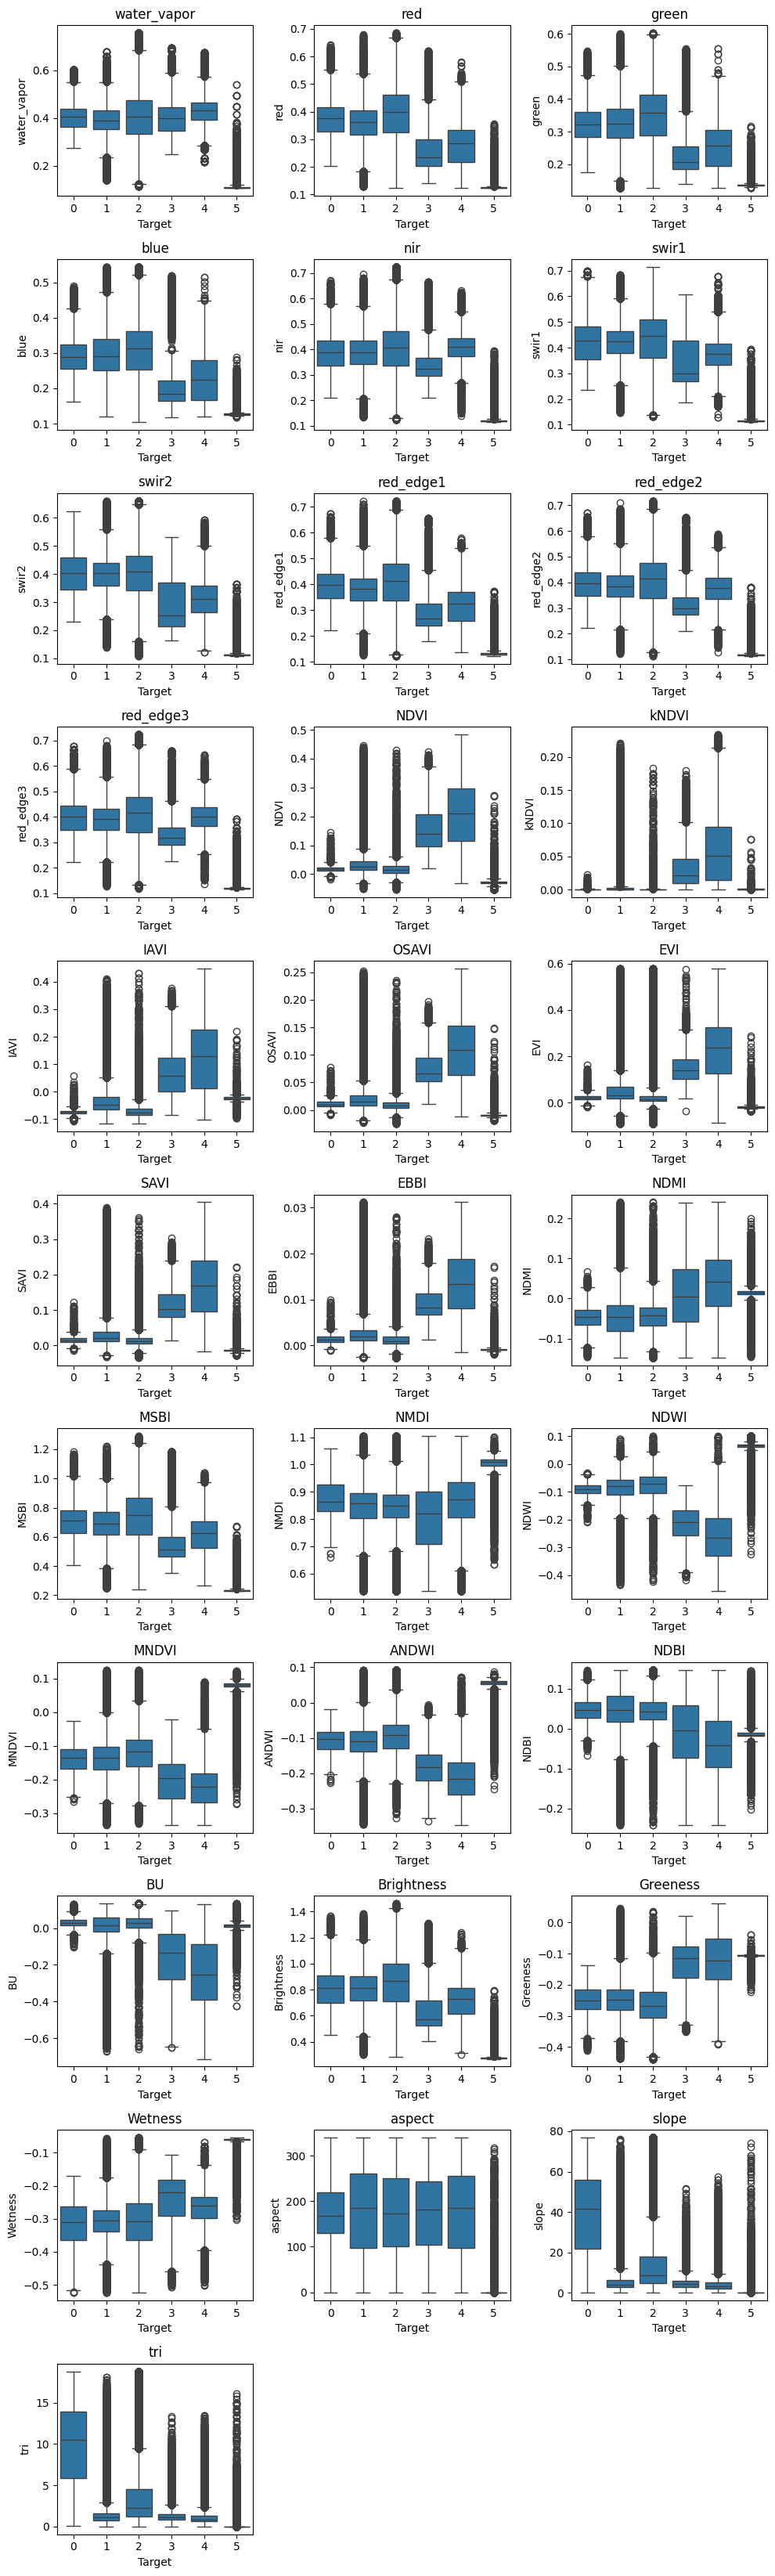

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of columns to plot (excluding the 'target' column)
columns_to_plot = df_clean.columns[:-1]  # Exclude 'target'
df_clean['target'] = df_clean['target'].astype(int)

# Set the number of rows and columns for the grid
n_cols = 3  # Number of columns in the grid (adjust as needed)
n_rows = -(-len(columns_to_plot) // n_cols)  # Calculate the required number of rows

# Create the figure with the appropriate size
plt.figure(figsize=(10, n_rows * 3))  # Adjust the figure size based on the grid

# Create boxplots for each column
for i, column in enumerate(columns_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)  # Adjust for the grid layout
    sns.boxplot(x='target', y=column, data=df_clean)
    plt.title(column)
    plt.xlabel('Target')
    plt.ylabel(column)

plt.tight_layout()  # Adjust layout
plt.show()

In [ ]:
y = df_clean["target"]
X = df_clean.drop(columns=['target'], errors='ignore')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 1: Check for infinite and NaN values
if np.isinf(X_train.to_numpy()).any():  # Convert DataFrame to NumPy array for checking
    print("Infinite values detected in X_train")

if X_train.isnull().values.any():  # Using .values to check for NaN
    print("NaN values detected in X_train")

# Step 2: Clean the data
#X_train.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
#X_train.fillna(X_train.mean(), inplace=True)  # Replace NaN with the mean of each column
#X_test.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
#X_test.fillna(X_train.mean(), inplace=True)  # Replace NaN with the mean of each column
# Step 3: Ensure all data is float type
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Step 4: Fit the scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

print("Scaled X_train:")
print(X_train)

# Fit the scaler on the training data and transform it
#X_train = scaler.fit_transform(X_train)
# Use the same transformation on the test data
X_test = scaler.transform(X_test)


joblib.dump(scaler, outputPath+'/scaler.pkl')  # Save the scaler

Scaled X_train:
[[-1.32860405 -1.42714153 -1.25326334 ... -1.01499228  1.21280283
   1.22961223]
 [-0.24839126 -0.54713805 -0.83325931 ...  1.34909803  0.21206215
   0.14745474]
 [ 0.00403208 -0.08439206 -0.32712567 ...  0.02310178 -0.07399785
  -0.10976148]
 ...
 [-0.7621617  -0.9005253  -1.02369139 ... -0.15231574 -0.0675325
  -0.06844892]
 [-0.35373582  0.17441353  0.01932944 ...  0.68727285 -0.39870536
  -0.46342994]
 [-0.43087578  0.05410864  0.32175153 ... -1.09346701 -0.50768776
  -0.54768429]]


['/content/drive/MyDrive/Work/Gruner_2024/ML_grid/clases/Proyecto_Xema_1/output/scaler.pkl']

[Regresar al inicio](#top)

<a name="model"></a>
# Diseño del modelo FNN para clasificación

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau
#from tensorflow.keras.activations import LeakyReLU
#from keras.layers.LeakyReLU  import LeakyReLU
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Check the shapes of your training and testing data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Convert labels to categorical format
y_train_cat = to_categorical(y_train, num_classes=7)
y_test_cat = to_categorical(y_test, num_classes=7)

# Define the model
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),  # First hidden layer
    BatchNormalization(),
    Dropout(0.3),  # Regularization to avoid overfitting

    Dense(64, activation='relu'),  # Second hidden layer
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),  # Third hidden layer
    BatchNormalization(),
    Dropout(0.3),

    Dense(6, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical crossentropy
              metrics=['accuracy'])  # You can add more metrics as needed

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


X_train shape: (2505590, 31), y_train shape: (2505590,)
X_test shape: (1073825, 31), y_test shape: (1073825,)


In [ ]:
y_train_cat = to_categorical(y_train, num_classes=6)
y_test_cat = to_categorical(y_test, num_classes=6)

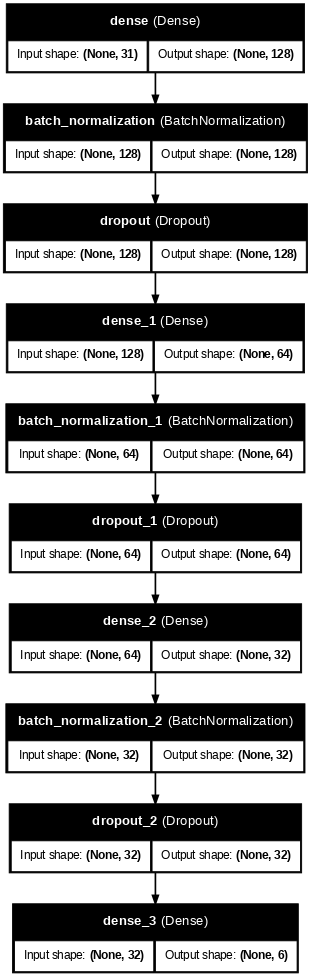

In [ ]:
from keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file= outputPath + '/model_architecture.png', show_shapes=True, show_layer_names=True, dpi=60)

[Regresar al inicio](#top)

<a name="train"></a>
# Entrenamiento del modelo

In [ ]:
# Train the model
history = model.fit(X_train, y_train_cat, epochs=25,
                    validation_data=(X_test, y_test_cat),
                    batch_size=32,
                    verbose=1,
                    callbacks=[early_stopping])

# Evaluate the model on the test data
results = model.evaluate(X_test, y_test_cat, verbose=1)

# Extracting test metrics
test_loss = results[0]
test_accuracy = results[1]

# Displaying the results
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/25
78300/78300 ━━━━━━━━━━━━━━━━━━━━ 180s 2ms/step - accuracy: 0.8951 - loss: 0.3070 - val_accuracy: 0.9496 - val_loss: 0.1373
Epoch 2/25
78300/78300 ━━━━━━━━━━━━━━━━━━━━ 171s 2ms/step - accuracy: 0.9308 - loss: 0.1996 - val_accuracy: 0.9563 - val_loss: 0.1211
Epoch 3/25
78300/78300 ━━━━━━━━━━━━━━━━━━━━ 171s 2ms/step - accuracy: 0.9363 - loss: 0.1835 - val_accuracy: 0.9601 - val_loss: 0.1111
Epoch 4/25
78300/78300 ━━━━━━━━━━━━━━━━━━━━ 171s 2ms/step - accuracy: 0.9394 - loss: 0.1752 - val_accuracy: 0.9604 - val_loss: 0.1104
Epoch 5/25
78300/78300 ━━━━━━━━━━━━━━━━━━━━ 171s 2ms/step - accuracy: 0.9416 - loss: 0.1689 - val_accuracy: 0.9633 - val_loss: 0.1035
Epoch 6/25
78300/78300 ━━━━━━━━━━━━━━━━━━━━ 172s 2ms/step - accuracy: 0.9425 - loss: 0.1661 - val_accuracy: 0.9635 - val_loss: 0.1033
Epoch 7/25
78300/78300 ━━━━━━━━━━━━━━━━━━━━ 172s 2ms/step - accuracy: 0.9441 - loss: 0.1616 - val_accuracy: 0.9643 - val_loss: 0.1006
Epoch 8/25
78300/78300 ━━━━━━━━━━━━━━━━━━━━ 172s 2ms/step - ac

[Regresar al inicio](#top)

<a name="performance"></a>
# Desempeño del modelo

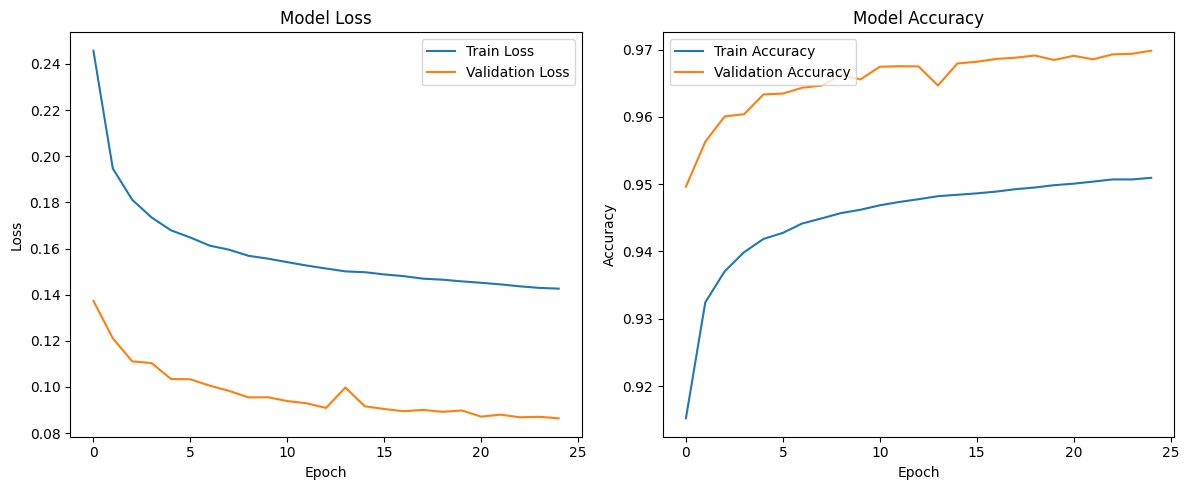

In [ ]:
# Plot training & validation accuracy, loss, and AUC
#epochs = range(1, len(history.history['loss']) + 1)

# Optional: Plot training history
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

33558/33558 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step


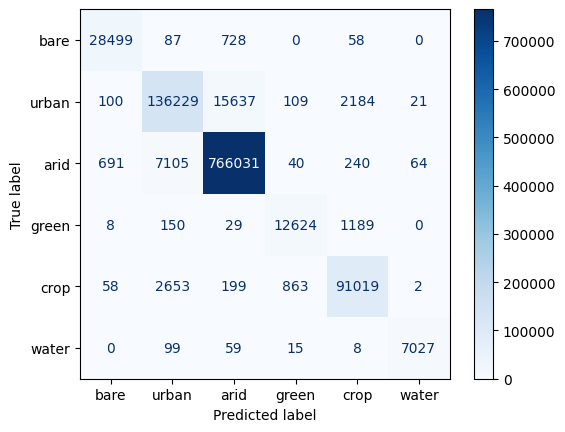

              precision    recall  f1-score   support

        bare       0.97      0.97      0.97     29372
       urban       0.93      0.88      0.91    154280
        arid       0.98      0.99      0.98    774171
       green       0.92      0.90      0.91     14000
        crop       0.96      0.96      0.96     94794
       water       0.99      0.97      0.98      7208

    accuracy                           0.97   1073825
   macro avg       0.96      0.95      0.95   1073825
weighted avg       0.97      0.97      0.97   1073825



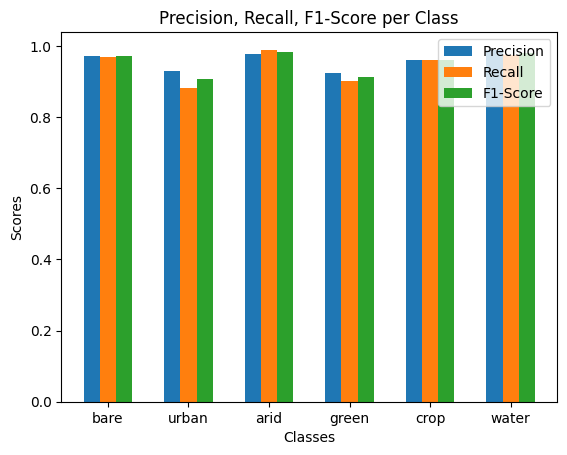

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Predict on the test set
y_pred = np.argmax(model.predict(X_test), axis=1)  # Get the predicted class (argmax of softmax output)
classes = ['bare', 'urban', 'arid', 'green', 'crop', 'water']


# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report: precision, recall, and F1-score per class
print(classification_report(y_test, y_pred, target_names = classes))

# Plot Precision, Recall, F1-score for each class
report = classification_report(y_test, y_pred, target_names = classes, output_dict=True)
# Extract values for precision, recall, and f1-score
precision = [report[cls]['precision'] for cls in classes]
recall = [report[cls]['recall'] for cls in classes]
f1_score = [report[cls]['f1-score'] for cls in classes]

# Create bar plot
x = np.arange(len(classes))
width = 0.2  # width of the bars

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1-Score')

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Precision, Recall, F1-Score per Class')
plt.xticks(x, classes)
plt.legend()
plt.show()

33558/33558 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step


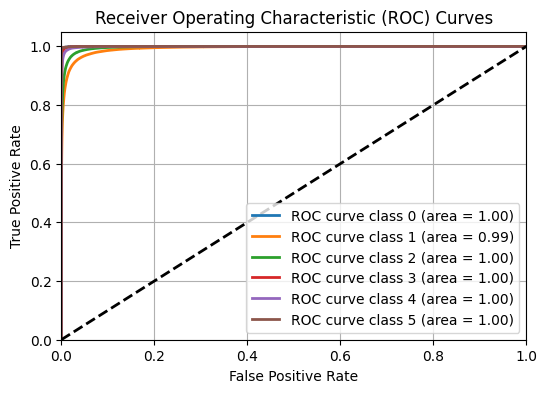

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming you have y_test and model predictions
y_pred_prob = model.predict(X_test)

# Binarize the output for multi-class ROC
# Assuming your labels are 0, 1, 2, 3, 4, 5
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves
plt.figure(figsize=(6, 4))

# Plot each ROC curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Add labels, title, and legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
model.save(outputPath+'/best_model_classes.keras')

In [ ]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming df is your combined dataframe
X = df.drop('target', axis=1)  # Features
y = df['target']  # Target (optional for unsupervised learning)

# Scale the features for better clustering results
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method to find the optimal number of clusters
inertia = []
for i in range(1, 11):  # Test for 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow method graph
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Choose the number of clusters based on the elbow point in the graph
optimal_k = 8# Insert the number of clusters based on the elbow method graph

# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_scaled)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

# Add cluster labels to your dataframe
df['cluster'] = cluster_labels


SyntaxError: invalid syntax (<ipython-input-34-db25fdff9f2e>, line 28)

[Regresar al inicio](#top)

<a name="predict"></a>
# Predicción

In [ ]:

from keras.models import load_model
import joblib
# Load the model from a .h5 file
model = load_model(outputPath+'/best_model_classes.keras')
# When loading the model later, reload the scaler
scaler = joblib.load(outputPath+'/scaler.pkl')


In [ ]:


# Define class labels
class_labels = {
    0: 'Desnudo',
    1: 'Urbano',
    2: 'Árido',
    3: 'Vegetación',
    4: 'Cultivo',
    5: 'Agua'#,
    #6: 'Desnudo'
}

# Define random colors for each class
colors = ['#390260', '#82119b', '#d3cdd3', '#636338', '#06293d', '#d39b2c']
cmap = mcolors.ListedColormap(colors)

# Normalize the classes to match the color map
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]  # 8 values to define 7 class boundaries
norm = mcolors.BoundaryNorm(bounds, cmap.N)

yr_0 = 2024
#yr_1 = 2024
# Set range of time to return data for one full year
time_range = (str(yr_0) + "-01-01", str(yr_0) + "-01-30")

In [ ]:

#lat_long = (-33.2833, -70.8756)
#box_size_deg = 0.05
#time_extents = ('2023-01-01', '2023-01-31')
# Calculate the latitude and longitude bounds of the analysis box
#latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
#longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

#display_map(latitude,longitude)

In [ ]:
#import geopandas as gpd
#shapefile = "/content/drive/MyDrive/Work/Gruner_2024/ML_grid/testSite2.shp"
shapefile = "/content/drive/MyDrive/Work/Gruner_2024/Conelsur/franja.shp"

time_extents = ('2024-05-23', '2024-05-24')

boundary_shp = gpd.read_file(shapefile)
boundary_shp
limits = boundary_shp.total_bounds
limits
latitude = (limits[1], limits[3])
longitude = (limits[0], limits[2])

In [ ]:

dem_dataset = dc.load(latitude=latitude, longitude=longitude, product=dem_product)
dem_dataset = dem_dataset.rio.reproject(output_crs)
elevation = dem_dataset.elevation.squeeze().drop('time')
ds1 = elevation.to_dataset()

# Calculate slope and aspect
resolution_dem = 30  # Set resolution based on your DEM
dy, dx = np.gradient(elevation, resolution_dem)
aspect = np.arctan2(-dx, dy)
aspect_degrees = np.degrees(aspect)
aspect_degrees = (aspect_degrees + 360) % 360
flat_areas = (dy == 0) & (dx == 0)
aspect_degrees[flat_areas] = -1
ds1['aspect'] = (('y', 'x'), aspect_degrees)

slope_radians = np.arctan(np.sqrt(dx**2 + dy**2))
slope_percentage = np.tan(slope_radians) * 100
ds1["slope"] = (('y', 'x'), slope_percentage)

# TRI calculation
tri = calculate_tri(dem_dataset)  # Assuming calculate_tri is a predefined function
ds1["tri"] = elevation
tri_resampled = tri.squeeze().drop('time').interp_like(ds1['elevation'])
ds1["tri"].data = tri_resampled.data

# Load Sentinel-2 data and calculate indices
coverage_table = build_cloud_coverage_table_sentinel(product = product,
                                                    platform = platform,
                                                    latitude = latitude,
                                                    longitude = longitude,
                                                    time = time_range,
                                                    #group_by='solar_day',
                                                    #measurements=bands,
                                                    dc = dc,
                                                    extra_band = 'green')
#sentinel_dataset,


In [ ]:
sentinel_dataset = dc.load(
    latitude=latitude,
    longitude=longitude,
    platform=platform,
    time=time_range,
    product=product,
    group_by='solar_day',
    measurements=bands
)
#sentinel_dataset = sentinel_dataset.rio.reproject(output_crs)
data = to_f32(sentinel_dataset, scale=scale, offset=offset)  # Assuming to_f32 is a predefined function


In [ ]:
percent_clean = 80
s2_clean_mask = (data.scl != 0) & (data.scl != 1) & \
                (data.scl != 3) & (data.scl != 8) & \
                (data.scl != 9) & (data.scl != 10)
data = data.where(s2_clean_mask)
#to do:
#filtered_scenes = cloud_coverage_table[cloud_coverage_table['Clean_percent'] > 90]
#refined_mask = s2_clean_mask & (data.swir1 < 0.3)  # Mask clouds with high SWIR reflectance


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Generate random colors for each SCL class
unique_classes = np.unique(data.scl)
num_classes = len(unique_classes)
colors = plt.cm.tab20(np.linspace(0, 1, num_classes))  # Generate distinguishable colors

# Create a colormap and a normalization object
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(unique_classes - 0.5, cmap.N)

# Plot the SCL layer
plt.figure(figsize=(10, 8))
im = plt.imshow(data.scl, cmap=cmap, norm=norm)
plt.colorbar(im, ticks=unique_classes, label='SCL Class')

# Add labels for SCL classes
scl_labels = {
    0: "No Data",
    1: "Saturated/Defective",
    2: "Dark Features/Shadow",
    3: "Cloud Shadows",
    4: "Vegetation",
    5: "Bare Soils",
    6: "Water",
    7: "Unclassified",
    8: "Cloud Medium Probability",
    9: "Cloud High Probability",
    10: "Thin Cirrus",
    11: "Snow/Ice"
}

# Generate a custom legend
legend_patches = [plt.Line2D([0], [0], color=colors[i], lw=4, label=f'{cls}: {scl_labels.get(cls, "Unknown")}')
                  for i, cls in enumerate(unique_classes)]

plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="SCL Classes")
plt.title("Sentinel-2 Scene Classification (SCL)")
plt.xlabel("X Pixel")
plt.ylabel("Y Pixel")
plt.tight_layout()
plt.show()


In [ ]:
s2_df = pd.DataFrame(list(zip(data.time.values.astype('datetime64[D]'),
                              [round(mask.mean().item()*100, 2) for mask in s2_clean_mask],
                              [mask.sum().item() for mask in s2_clean_mask])),
                     columns=['Sentinel-2 Date', 'clean_pixel_percent', 'clean_pixel_count'])\
                     .query(f'clean_pixel_percent >= {percent_clean}')
s2_df

,Sentinel-2 Date,clean_pixel_percent,clean_pixel_count
0,2024-01-02,100.00,4120948
1,2024-01-05,100.00,4120948
2,2024-01-07,100.00,4120948
3,2024-01-10,100.00,4120948
4,2024-01-12,99.64,4106065
5,2024-01-15,100.00,4120948
6,2024-01-17,100.00,4120948
7,2024-01-20,100.00,4120948
8,2024-01-22,98.95,4077776
9,2024-01-25,100.00,4120948


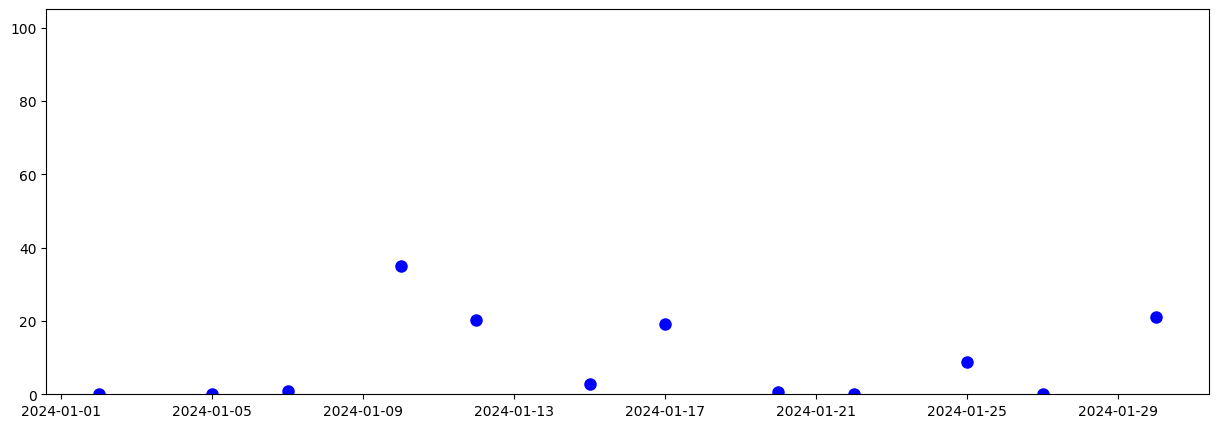

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(coverage_table["Date"].values, coverage_table["Clean_percent"].values, 'bo', markersize=8)
plt.ylim([0, 105])
plt.show()

In [ ]:
s2_clean_mask = (data.scl != 0) & (data.scl != 1) & \
                (data.scl != 3) & (data.scl != 8) & \
                (data.scl != 9) & (data.scl != 10)

In [ ]:
data = data.rio.reproject(output_crs)


In [ ]:


# Calculate indices
data["NDMI"] = (data.nir - data.swir1) / (data.nir  + data.swir1)
data["MSBI"] = (0.406*data.green) + (0.60*data.red) + (0.645*data.red_edge2) + (0.243*data.water_vapor) #https://www.indexdatabase.de/db/i-single.php?id=570
data["MNDVI"] = (data.green - data.swir1) / (data.green + data.swir1)
data["IAVI"] = (data.nir - (data.red - ((1.12 + 0.65) / 2)*(data.blue - data.red))) / (data.nir + (data.red - ((1.12 + 0.65) / 2)*(data.blue - data.red)))
data["OSAVI"] = ((1 + 0.16)*(data.nir - data.red)) / (data.nir + data.swir1 + 0.61)
data["EVI"] = 2.5 * (data.nir - data.red) / (data.nir + (6.0*data.red) - (7.5*data.blue)+ 1)
data["SAVI"] = ((data.nir-data.red) / (data.nir + data.red + 0.5)) * (1+0.5)
data["EBBI"] = (data.nir-data.red) / (10 * np.sqrt(data.nir + 0.5))
data["NMDI"] = (data.nir  - ( data.swir1 - data.red_edge2 ) ) / ( data.nir  + ( data.swir1 - data.swir2) )
data["NDVI"] = (data.nir  - data.red) / (data.nir  + data.red)
data["NDWI"] = (data.green - data.nir ) / (data.green + data.nir ) #https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndwi/
data["NDSI"] = (data.green - data.swir1) / (data.green + data.swir1) # https://doi.org/10.5194/essd-11-493-2019
data["NDBI"] = (data.swir1 - data.nir ) / (data.swir1 + data.nir )
data["BU"] = data.NDBI - data.NDVI # https://www.tandfonline.com/doi/pdf/10.1080/01431161.2010.481681
data['ANDWI'] = (data['blue']+data['green']+data['red']-data['nir']-data['swir1']-data['swir2']) / (data['blue']+data['green']+data['red']+data['nir']+data['swir1']+data['swir2'])
sigma = 0.5*(data['nir'] + data['red'])
knr = np.exp(-(data['nir'] - data['red'])**2/(2*sigma**2))
data['kNDVI'] = (1-knr) / (1+knr)
data['Brightness'] = 0.3510*data['blue'] + 0.3813*data['green'] + 0.3437*data['red'] + 0.7196*data['nir'] + 0.2396*data['swir1'] + 0.1949*data['swir2']
data['Greeness'] = -0.3599*data['blue'] - 0.3533*data['green'] - 0.4734*data['red'] + 0.6633*data['nir'] + 0.0087*data['swir1'] - 0.2856*data['swir2']
data['Wetness'] = 0.2578*data['blue'] + 0.2305*data['green'] + 0.0883*data['red'] + 0.1071*data['nir'] - 0.7611*data['swir1'] - 0.5308*data['swir2']

# Monthly mean indices
mean_indices = data[indices].groupby('time.month').mean('time')
mean_indices = mean_indices.dropna(dim='month', how='all')

# Merge DEM data
mean_indices['elevation'] = ds1.elevation.interp(y=mean_indices["y"], x=mean_indices["x"])
mean_indices['aspect'] = ds1.aspect.interp(y=mean_indices["y"], x=mean_indices["x"])
mean_indices['slope'] = ds1.slope.interp(y=mean_indices["y"], x=mean_indices["x"])
mean_indices['tri'] = ds1.tri.interp(y=mean_indices["y"], x=mean_indices["x"])

# Filtering and clipping
mean_indices = mean_indices.where(mean_indices['elevation'] > 0, drop=False)
mean_indices = mean_indices.squeeze().drop('elevation')


NameError: name 'data' is not defined

In [ ]:
import xarray as xr
import numpy as np
import rasterio
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Assume 'annual_mean_indices' is your dataset and 'scaler' is your fitted scaler
dataset = mean_indices

# Clean the dataset
for var in dataset.data_vars:
    dataset[var] = dataset[var].where(~np.isinf(dataset[var]), np.nan)
    dataset[var] = dataset[var].fillna(0)

# Flatten each data variable and stack them
data_vars = [dataset[var].values.flatten() for var in dataset.data_vars]
raster_stack = np.vstack(data_vars).T  # Shape: (n_pixels, n_bands)

# Scale the data
scaled_raster_stack = scaler.transform(raster_stack)

# Run predictions (use np.argmax if the model outputs probabilities)
predictions = np.argmax(model.predict(scaled_raster_stack), axis=1)  # Get class indices

# Reshape predictions back to the original raster dimensions
height, width = dataset.dims['y'], dataset.dims['x']
predicted_raster = predictions.reshape((height, width))

# Replace NaNs in the predicted raster if needed (use a value suitable for your analysis)
predicted_raster = np.nan_to_num(predicted_raster, nan=0)  # or handle NaNs differently

# Output the prediction as a raster
transform = dataset.rio.transform()
crs = dataset.rio.crs

output_path = outputPath+'/predicted_classes6_Conelsur.tif'
with rasterio.open(
    output_path, 'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,  # 1 band for predictions
    dtype=np.int32,  # Ensure the dtype is appropriate for class labels
    crs=crs,
    transform=transform,
) as dst:
    dst.write(predicted_raster.astype(np.int32), 1)  # Ensure the correct type when writing

print("Prediction raster saved successfully.")

134271/134271 ━━━━━━━━━━━━━━━━━━━━ 154s 1ms/step
Prediction raster saved successfully.


[Regresar al inicio](#top)

<a name="view"></a>
# Visualización

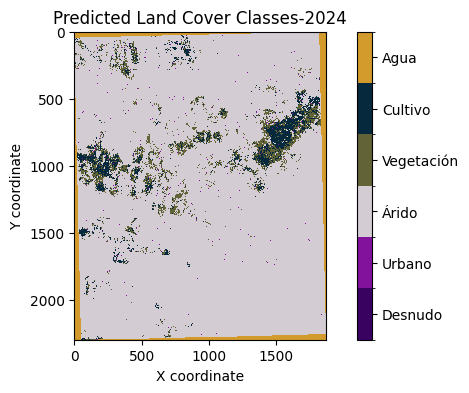

In [ ]:

# Plot the raster with the custom color map
plt.figure(figsize=(8, 4))
img = plt.imshow(predicted_raster, cmap=cmap, norm=norm, interpolation='nearest')

# Create a color bar with class labels
cbar = plt.colorbar(img, ticks=[0, 1, 2, 3, 4, 5])
cbar.ax.set_yticklabels([class_labels[i] for i in range(6)])  # Set class labels

# Add title and axis labels
plt.title(f'Predicted Land Cover Classes-{yr_0}')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

plt.savefig(outputPath +'/multiClass.png', format='png', bbox_inches='tight', dpi=500)
plt.show()

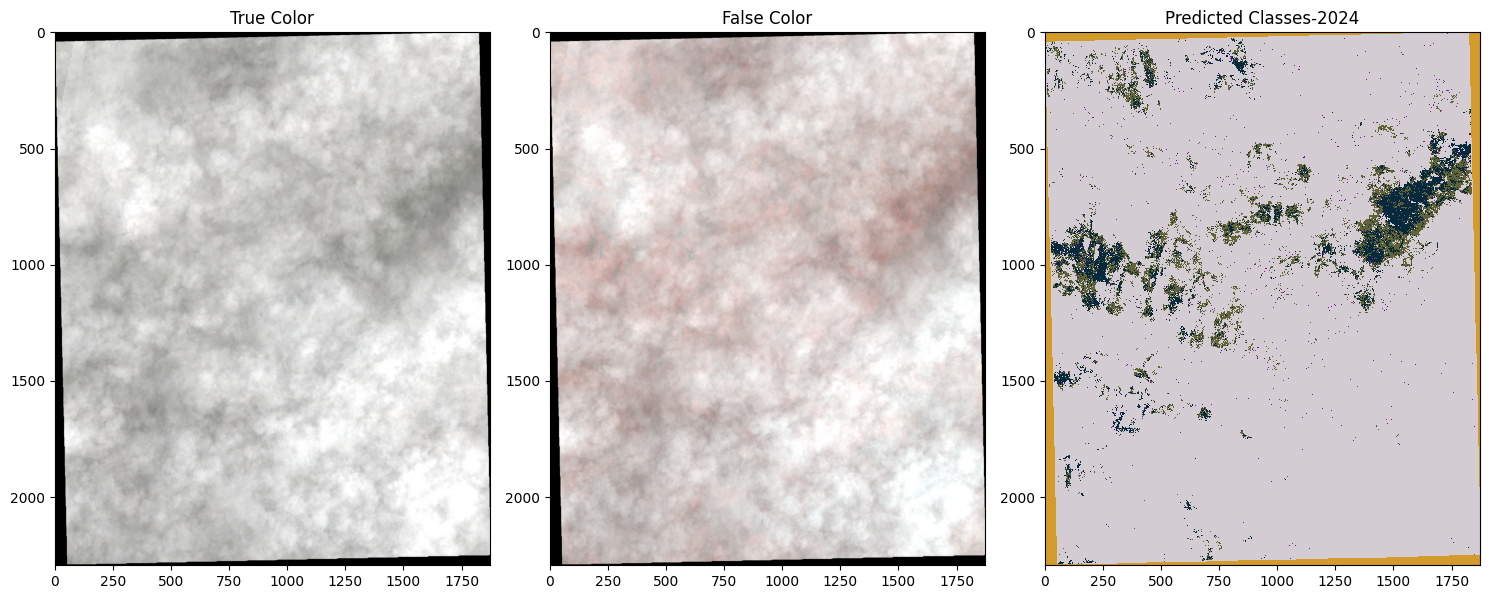

In [ ]:
# Create a 1x2 subplot grid
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

# Plot 1: True Color
plot_true_color(mean_indices, ax=axes[0])  # True color image on the first subplot

# Plot 1: True Color
plot_false_color(mean_indices, ax=axes[1])  # True color image on the first subplot

# Plot 2: Prediction raster
axes[2].imshow(predicted_raster, cmap=cmap, norm=norm, interpolation='nearest')
# Add title and axis labels
plt.title(f'Predicted Classes-{yr_0}')
# Adjust layout
plt.tight_layout()

# Show the plots together
plt.savefig(outputPath + '/multi_class_image1.png', format='png', bbox_inches='tight', dpi=500)
plt.show()

In [ ]:
mean_indices["predict"] = mean_indices["NDVI"]

In [ ]:
mean_indices["predict"].data = predicted_raster

In [ ]:
pred_ras = mean_indices["predict"].to_dataset()

In [ ]:
type(pred_ras)

xarray.core.dataset.Dataset

In [ ]:
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

Original min: 0, max: 255



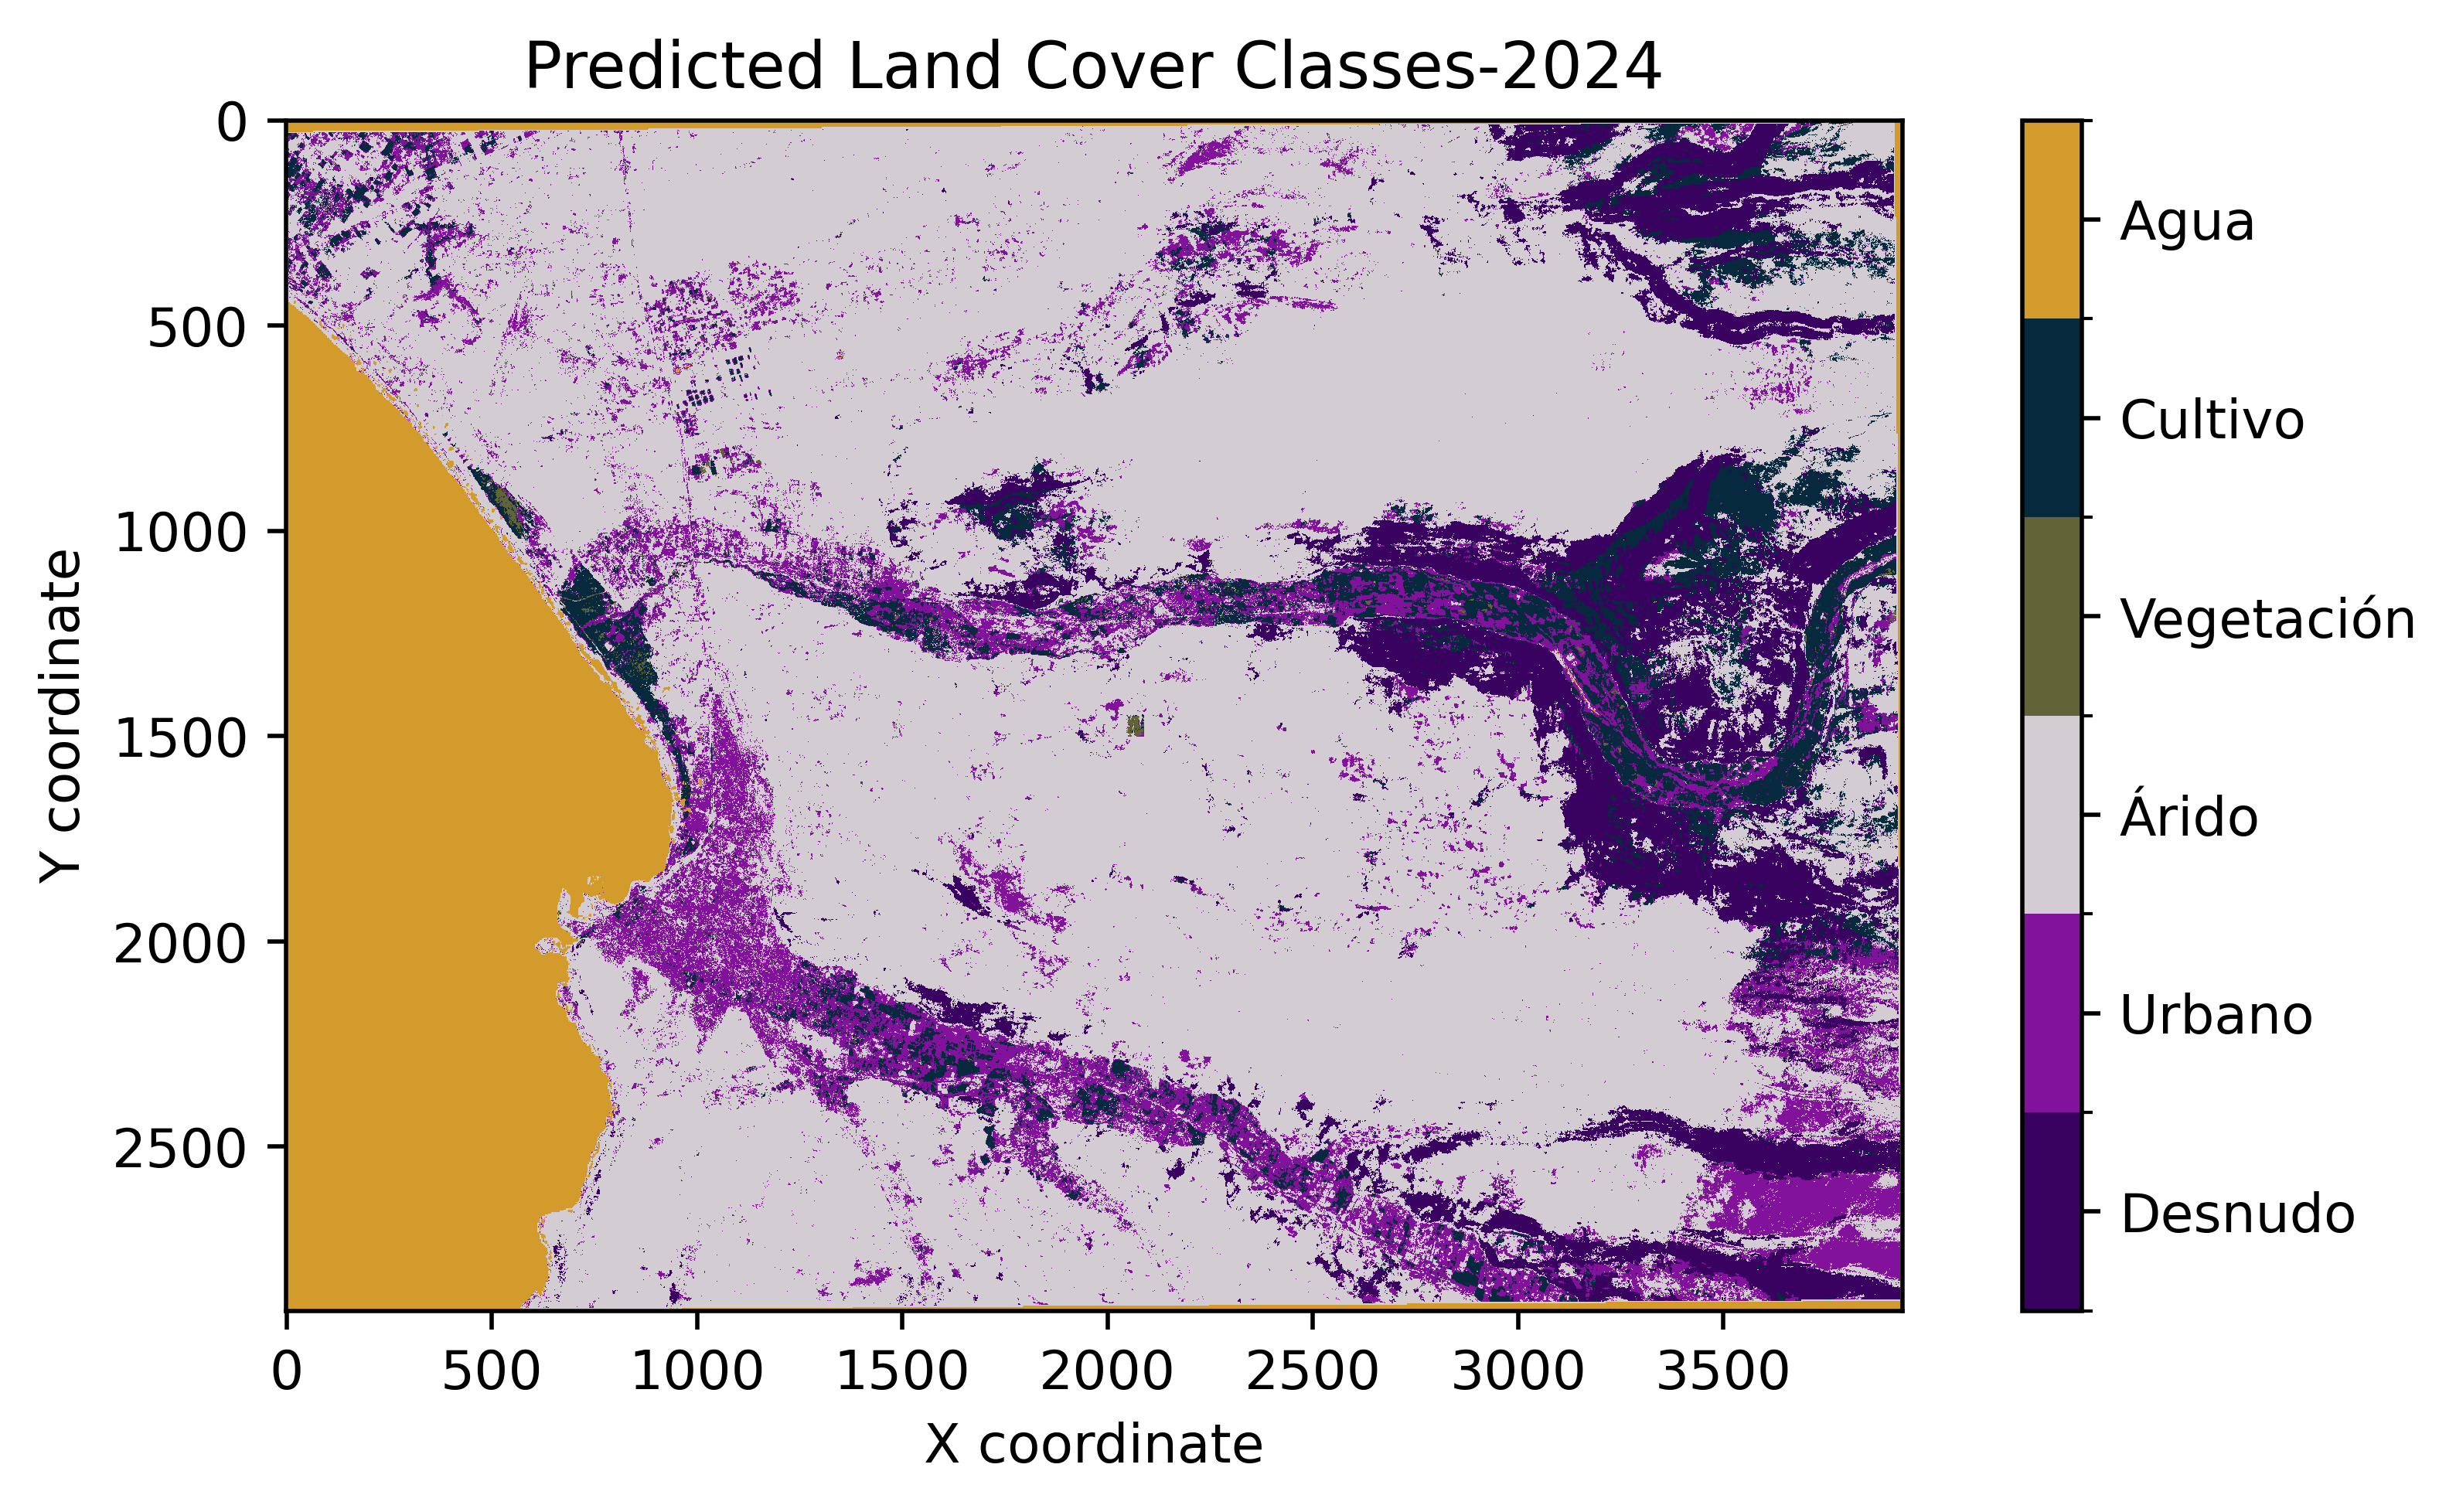

In [ ]:

import folium
from folium.raster_layers import ImageOverlay
from PIL import Image

# Load and reproject the image as needed
image_path = outputPath +'/multiClass.png'#output_path

# Initialize a folium map at a starting location

# Initialize the folium map, but with no default tiles
m = folium.Map(location=[latitude[0], longitude[1]], zoom_start=8, tiles=None)

# Add Google Maps hybrid tiles
folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}",
    attr="Google",
    name="Google Maps Hybrid",
    overlay=False,
    control=True,
).add_to(m)

# Overlay the image
# Open the TIFF image with rasterio
with rasterio.open(image_path) as src:
    # Read the data as a numpy array
    image_array = src.read(1)  # Read the first band, assuming grayscale

    # Check the min and max values for normalization
    min_val, max_val = image_array.min(), image_array.max()
    print(f"Original min: {min_val}, max: {max_val}")

    # Normalize the array to 0-255 for display
    image_array = ((image_array - min_val) / (max_val - min_val) * 255).astype(np.uint8)

    # Convert numpy array to PIL Image
    image = Image.fromarray(image_array, mode="L")  # "L" mode is grayscale

# If you need RGB, replicate the grayscale bands
image = image.convert("RGB")

# Save the image as a PNG for Folium
png_image_path = outputPath +'/multiClass.png'#"output_map.png"
#image.save(png_image_path)

bounds = [[latitude[0], longitude[0]], [latitude[1], longitude[1]]]  # Bounding box coordinates for the image

# Add ImageOverlay with transparency
folium.raster_layers.ImageOverlay(
    image=png_image_path,
    bounds=bounds,
    opacity=0.6,  # Adjust transparency (0 = fully transparent, 1 = opaque)
    interactive=True,
).add_to(m)

# Add layer control and display map
folium.LayerControl().add_to(m)
m



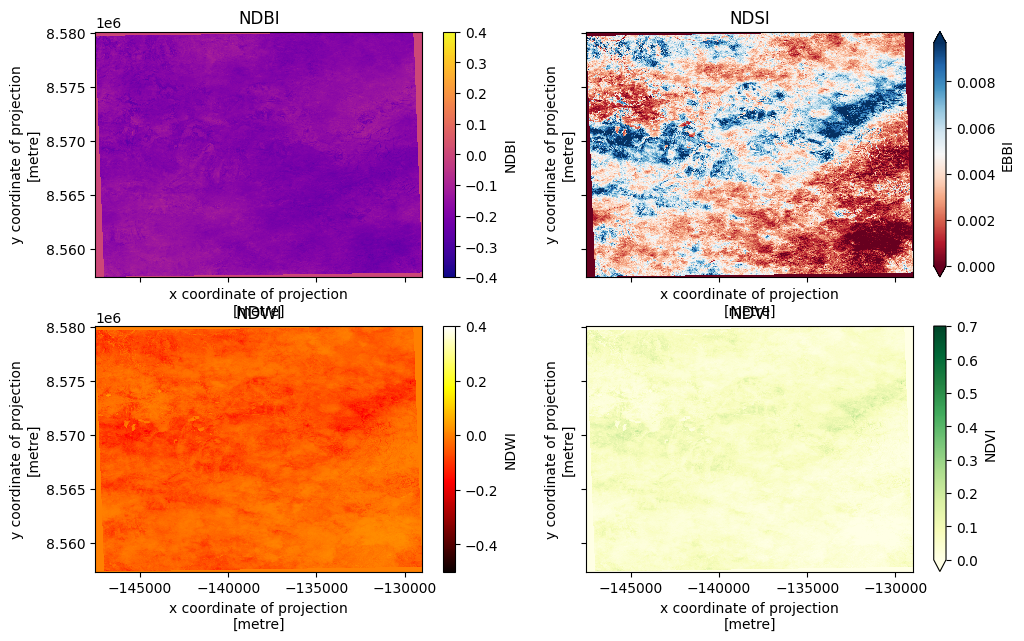

In [ ]:
fig1, f1_axes = plt.subplots(nrows=2, ncols=2, sharex="col", sharey="row")#, constrained_layout=True
fig1.set_size_inches(15, 9)
plt.subplot(221)
mean_indices["NDBI"].plot(vmin=-0.4,vmax=0.4, cmap="plasma")#,vmin=0.2, vmax=1)
plt.title("NDBI")
plt.subplot(222)
mean_indices["EBBI"].plot(robust=True, cmap="RdBu")#,vmin=0.2, vmax=1)
plt.title("NDSI")
plt.subplot(223)
mean_indices["NDWI"].plot(vmin=-0.5,vmax=0.4, cmap="hot")#, vmin=0, vmax=0.2)
plt.title("NDWI")
plt.subplot(224)
mean_indices["NDVI"].plot(vmin=0,vmax=0.7, cmap= "YlGn")#, vmin=-0.3, vmax=0.3)
plt.title("NDVI")

plt.subplots_adjust(bottom=0.2, top=0.8, left=0.2, right=0.8, wspace=0.2, hspace= 0.2)
plt.savefig(outputPath + '/indices_image1.png', format='png', bbox_inches='tight', dpi=500)

plt.show()

[Regresar al inicio](#top)